In [1]:
# --- KDD Stage 1: Selection ---
# Load the dataset
import pandas as pd

df = pd.read_csv('Ai Related Tweets.csv')
print(f"Initial Dataset Shape: {df.shape}")

# Filter tweets with 40 or more words
df_filtered = df[df['Tweets'].str.split().str.len() >= 40]
 
# Print the new shape of the dataset
print(f"Dataset Shape After Filtering (40+ words): {df_filtered.shape}")


Initial Dataset Shape: (27458, 3)
Dataset Shape After Filtering (40+ words): (11340, 3)


In [2]:
print(df_filtered.head())

   Serial                                             Tweets Sentiment
0     1.0  AI has experienced two fatal crashes as an ind...   neutral
2     3.0  Despite already existing problems in the music...  negative
3     4.0  The whole point of AI is to pump out more "pro...  negative
4     6.0  ThereÃ¢â‚¬â„¢s still lots to unpack with AI (L...  positive
6     8.0  AI is the current problem on that front, I'm h...  negative


In [3]:
# --- KDD Stage 2: Preprocessing ---
import re
import string

# Text cleaning function
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(f"[{string.punctuation}]", " ", text)  # Remove punctuation
    text = re.sub(r"\s+", " ", text).strip()  # Normalize spaces
    return text

# Apply text cleaning
df_filtered['cleaned_tweets'] = df_filtered['Tweets'].apply(clean_text)

# Standardize sentiment labels
df_filtered['Sentiment'] = df_filtered['Sentiment'].str.lower()
valid_sentiments = ['positive', 'negative', 'neutral']
df_filtered = df_filtered[df_filtered['Sentiment'].isin(valid_sentiments)]
df_filtered = df_filtered.drop(columns=['Serial'], errors='ignore')
df_filtered = df_filtered.dropna(subset=['Tweets', 'Sentiment'])
print(f"\nAfter cleaning and adding 'cleaned_tweets' column, final dataset shape is: {df_filtered.shape}\n")
print(df_filtered.head())



After cleaning and adding 'cleaned_tweets' column, final dataset shape is: (11340, 3)

                                              Tweets Sentiment  \
0  AI has experienced two fatal crashes as an ind...   neutral   
2  Despite already existing problems in the music...  negative   
3  The whole point of AI is to pump out more "pro...  negative   
4  ThereÃ¢â‚¬â„¢s still lots to unpack with AI (L...  positive   
6  AI is the current problem on that front, I'm h...  negative   

                                      cleaned_tweets  
0  ai has experienced two fatal crashes as an ind...  
2  despite already existing problems in the music...  
3  the whole point of ai is to pump out more prod...  
4  thereã¢â‚¬â„¢s still lots to unpack with ai ll...  
6  ai is the current problem on that front i m ha...  


C:\Users\seman\AppData\Local\Temp\ipykernel_14492\3029155030.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['cleaned_tweets'] = df_filtered['Tweets'].apply(clean_text)
C:\Users\seman\AppData\Local\Temp\ipykernel_14492\3029155030.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Sentiment'] = df_filtered['Sentiment'].str.lower()


In [4]:
# --- KDD Stage 3: Transformation ---
# Import libraries for text vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=10000)

X = df_filtered['cleaned_tweets']
y = df_filtered['Sentiment']
X_tfidf = vectorizer.fit_transform(X)

# Import libraries for train-test split
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=6, stratify=y)


In [5]:
# --- KDD Stage 4: Data Mining ---
# Import libraries for model training and evaluation
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    cohen_kappa_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)
import numpy as np

# Function to evaluate models, including Specificity
def evaluate_model(model_name, y_true, y_pred):
    print(f"\n{model_name} Evaluation:")

    # Standard Metrics
    accuracy = accuracy_score(y_true, y_pred)
    cohen_kappa = cohen_kappa_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Compute Specificity
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    specificity_scores = []
    # Compute Specificity for each class using the confusion matrix
    for i, label in enumerate(np.unique(y_true)):  # Loop through each class label in the true labels
        #Calculate True Negatives (TN)
        
        total_instances = cm.sum()
        
        # Sum of the elements in the current column (False Positives + True Positives)
        column_sum = cm[:, i].sum()
        
        # Sum of the elements in the current row (False Negatives + True Positives)
        row_sum = cm[i, :].sum()
        
        true_positives = cm[i, i]
        
        # True Negatives (TN) calculation:
        true_negatives = total_instances - (column_sum + row_sum - true_positives)

        
        # Calculate False Positives (FP)
        false_positives = column_sum - true_positives
        
        # Step 3: Calculate Specificity
        if (true_negatives + false_positives) > 0:
            specificity = true_negatives / (true_negatives + false_positives)
        else:
            specificity = 0
        specificity_scores.append(specificity)

    avg_specificity = np.mean(specificity_scores)

    print(f"accuracy: {accuracy:.2f}")
    print(f"cohen's kappa: {cohen_kappa:.2f}")
    print(f"Precision (weighted Avg): {precision:.2f}")
    print(f"Recall (weighted Avg - sensitivity): {recall:.2f}")
    print(f"f1 score (wighted Avg): {f1:.2f}")
    print(f"specificity (average): {avg_specificity:.2f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred))

    return accuracy, cohen_kappa, precision, recall, f1, avg_specificity
    
print("\n",df_filtered['Sentiment'].value_counts(normalize=True))

# Train and evaluate SVM
svm_model = SVC(kernel='linear',class_weight='balanced', random_state=6)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
svm_results = evaluate_model("SVM (banlanced) ", y_test, y_pred_svm)

# Train and evaluate Logistic Regression
logistic_model = LogisticRegression(max_iter=1000,class_weight='balanced', random_state=6)
logistic_model.fit(X_train, y_train)
y_pred_lr = logistic_model.predict(X_test)
lr_results = evaluate_model("Logistic Regression (balanced) ", y_test, y_pred_lr)

# Train and evaluate Random Forest
rf_model = RandomForestClassifier(n_estimators=100,class_weight='balanced', random_state=6)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rf_results = evaluate_model("Random Forest", y_test, y_pred_rf)



 Sentiment
negative    0.597354
neutral     0.286772
positive    0.115873
Name: proportion, dtype: float64

SVM (banlanced)  Evaluation:
accuracy: 0.66
cohen's kappa: 0.41
Precision (weighted Avg): 0.68
Recall (weighted Avg - sensitivity): 0.66
f1 score (wighted Avg): 0.67
specificity (average): 0.81

Classification Report:
               precision    recall  f1-score   support

    negative       0.80      0.74      0.77      1355
     neutral       0.51      0.53      0.52       650
    positive       0.45      0.59      0.51       263

    accuracy                           0.66      2268
   macro avg       0.59      0.62      0.60      2268
weighted avg       0.68      0.66      0.67      2268


Logistic Regression (balanced)  Evaluation:
accuracy: 0.67
cohen's kappa: 0.41
Precision (weighted Avg): 0.68
Recall (weighted Avg - sensitivity): 0.67
f1 score (wighted Avg): 0.67
specificity (average): 0.81

Classification Report:
               precision    recall  f1-score   support

 


Model Performance Summary:
                    SVM  Logistic Regression  Random Forest
Accuracy       0.664021             0.665344       0.671076
Cohen's Kappa  0.407213             0.412435       0.259465
Precision      0.678525             0.681867       0.697905
Recall         0.664021             0.665344       0.671076
F1-Score       0.669579             0.671317       0.606423
Specificity    0.810801             0.813050       0.738455


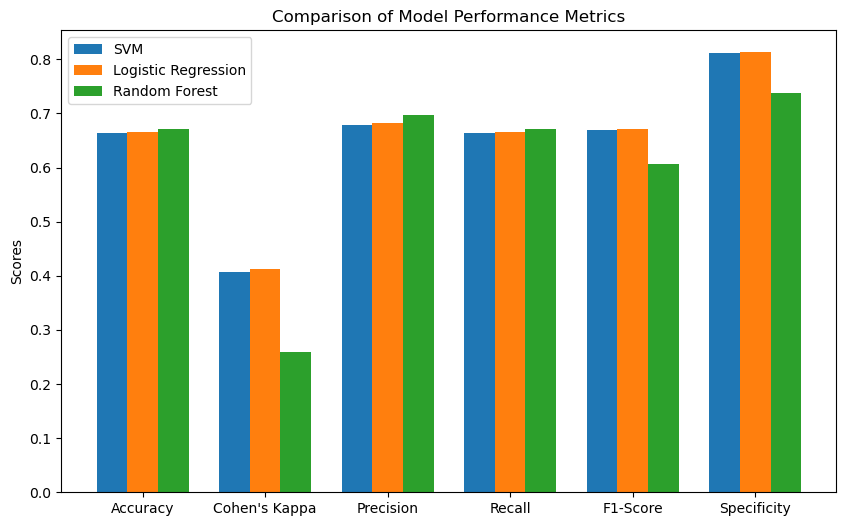

In [6]:
# --- KDD Stage 5: Interpretation/Evaluation ---
# Import visualization libraries
import matplotlib.pyplot as plt

# Store all results
results = pd.DataFrame({
    'SVM': svm_results,
    'Logistic Regression': lr_results,
    'Random Forest': rf_results
}, index=['Accuracy', "Cohen's Kappa", 'Precision', 'Recall', 'F1-Score', 'Specificity'])

print("\nModel Performance Summary:")
print(results)

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
metrics = results.index
x = np.arange(len(metrics))
width = 0.25

# Plot bars
ax.bar(x - width, results['SVM'], width, label='SVM')
ax.bar(x, results['Logistic Regression'], width, label='Logistic Regression')
ax.bar(x + width, results['Random Forest'], width, label='Random Forest')

# Add labels
ax.set_title("Comparison of Model Performance Metrics")
ax.set_ylabel("Scores")
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
plt.show()

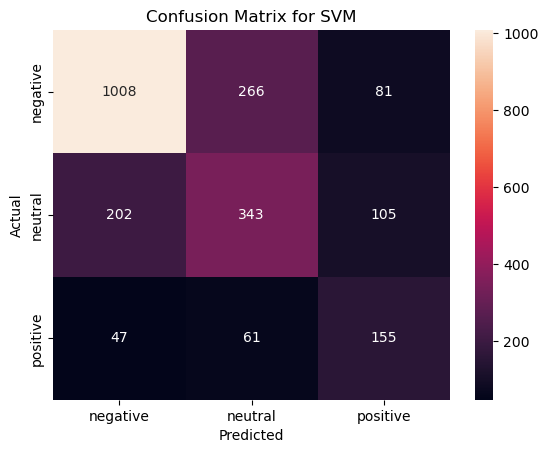

In [7]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_svm, labels=np.unique(y_test))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix for SVM")
plt.show()


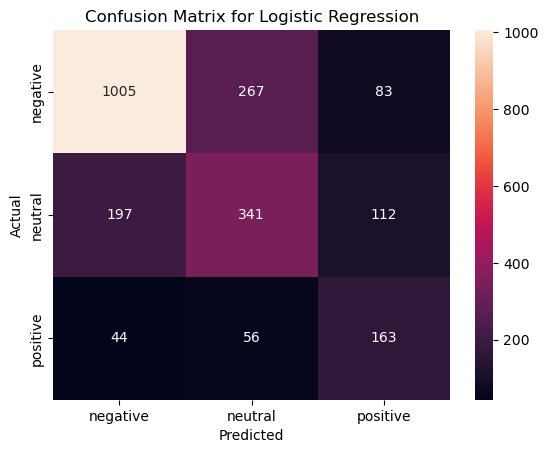

In [8]:
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Confusion Matrix for Logistic Regression")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

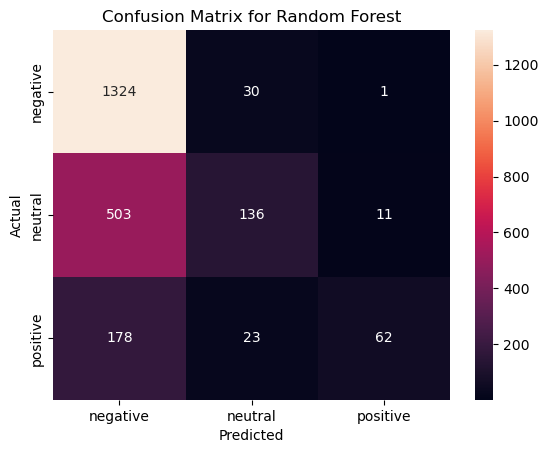

In [9]:
# Compute confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=np.unique(y_test))

# Plot confusion matrix for Random Forest

sns.heatmap(cm_rf, annot=True, fmt='d', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Confusion Matrix for Random Forest")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()